In [1]:
import re
import matplotlib as mpl

import glob
import os
import shutil
import traceback
import json
import cv2
import h5py

import math
import skimage
import time


import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import tifffile as tf
import cPickle as pkl
import matplotlib.colors as mcolors
import sklearn.metrics as skmetrics 
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pipeline.python import utils as putils
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.coregistration import align_fov as coreg
from pipeline.python.classifications import gradient_estimation as grd
from pipeline.python.classifications import aggregate_data_stats as aggr

from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


from skimage.color import label2rgb
#from skimage.measure import label, regionprops, find_contours
import skimage.measure as skmeasure
from skimage.measure import block_reduce


/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 65

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/paradigm/tifs_to_data_arrays.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py

In [2]:
%matplotlib inline

## Some aggregate plotting stuff

In [3]:
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params(lw_axes=2)

# Select colormap

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'azimuth_pos_nic_Edge_LEGEND_abs')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'elevation_pos_nic_Edge_LEGEND_abs')


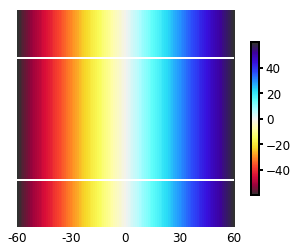

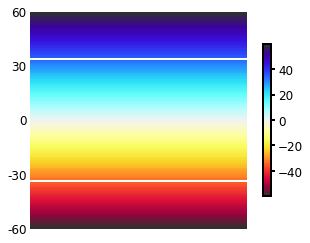

In [4]:
# # Load colormap
cmap_name = 'nic_Edge'
# zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=True, 
                                                   return_cmap=True)

# Set output dirs

In [5]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Metadata

In [6]:
# Get all data sets
traceid='traces001'

sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)
retinodata = sdata[sdata['experiment']=='retino'].copy()
retinodata.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum,datakey
visual_area,,,,,,
Li,23,23,23,23,23,23
Lm,19,19,19,19,19,19
V1,15,15,15,15,15,15


In [7]:
# screen info
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

# Do one at a time

In [8]:
curr_visual_area='V1'
retinodata[retinodata['visual_area']==curr_visual_area].sort_values(by=['animalid', 'session'])

,animalid,experiment,fov,session,visual_area,fovnum,datakey
123,JC076,retino,FOV1_zoom2p0x,20190420,V1,1,20190420_JC076_fov1
126,JC076,retino,FOV1_zoom2p0x,20190501,V1,1,20190501_JC076_fov1
162,JC083,retino,FOV1_zoom2p0x,20190507,V1,1,20190507_JC083_fov1
159,JC083,retino,FOV1_zoom2p0x,20190510,V1,1,20190510_JC083_fov1
167,JC083,retino,FOV1_zoom2p0x,20190511,V1,1,20190511_JC083_fov1
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1,20190522_JC084_fov1
41,JC085,retino,FOV1_zoom2p0x,20190622,V1,1,20190622_JC085_fov1
84,JC097,retino,FOV1_zoom2p0x,20190613,V1,1,20190613_JC097_fov1
69,JC097,retino,FOV2_zoom2p0x,20190615,V1,2,20190615_JC097_fov2
79,JC097,retino,FOV1_zoom2p0x,20190616,V1,1,20190616_JC097_fov1


# Example FOV ----------------------------------------------------------------------

In [10]:

cmap_name = 'nic_Edge'
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
#traceid='traces001'

animalid = 'JC097'
session = '20190613'
fov = 'FOV1_zoom2p0x'
retinorun='retino_run1'


# In[89]:

# Map filtering params
pix_mag_thr=0.002
delay_map_thr=1

# Smoothing params
# Marhsel et al 2014 (25um sigma)
# For some reson fill_and_smooth_nans_missing() fails if too covered
# smooth spline:  make 2 if >1 area
smooth_spline=1 
target_sigma_um=25 # 
start_with_transformed=True
use_phase_smooth=False

# Segmenting params
sign_map_thr = 0.1
min_region_area = 2000

absolute_S_thr=False
close_k = 91
open_k = 151
dilate_k =31 


reprocess=True
resmooth=True
interactive=True



In [73]:
datakey = '20190423_JC076_fov1' #'20190622_JC085_fov1'
session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])

# animalid = 'JC092'
# session = '20190528'
# fovnum = 1

fov = 'FOV%i_zoom2p0x' % fovnum
traceid = 'traces001'

#datakey='%s_%s_fov%i' % (session, animalid, fovnum)

# Get retino runs
found_retinoruns = [os.path.split(d)[-1] for d in 
                    glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))]
print("Found %i runs" % len(found_retinoruns))
retinorun = found_retinoruns[-1]
print(retinorun)

Found 1 runs
retino_run1


## Run step by step

In [74]:
# # Load data metainfo
# print("Current run: %s" % retinorun)
# retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
# data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
# print("DATA ID: %s" % data_id)

# # Load MW info and SI info
# mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
# scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
# trials_by_cond = scaninfo['trials']

# # Set current animal's retino output dir
# run_dir = RETID['DST'].split('/retino_analysis/')[0]
# curr_dst_dir = os.path.join(run_dir, 'retino_analysis', 'segmentation')
# if not os.path.exists(curr_dst_dir):
#     os.makedirs(curr_dst_dir)
#     print("Saving output to:\n %s" % curr_dst_dir)
    
# # Get run results
# magratio, phase, trials_by_cond = ret_utils.fft_results_by_trial(RETID)

# d2 = scaninfo['pixels_per_line']
# d1 = scaninfo['lines_per_frame']
# print("Original dims: [%i, %i]" % (d1, d2))

# # Get ROIID and projection image
# ds_factor = int(RETID['PARAMS']['downsample_factor'])
# print('Data were downsampled by %i.' % ds_factor)

# # Get pixel size
# pixel_size = putils.get_pixel_size()
# pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)


In [75]:
# pix_mag_thr=0.002

# abs_vmin, abs_vmax = (-np.pi, np.pi)
# absolute_az, absolute_el, delay_az, delay_el = ret_utils.absolute_maps_from_conds(magratio, phase, trials_by_cond,
#                                                                                  mag_thr=pix_mag_thr, dims=(d1, d2),
#                                                                                  plot_conditions=False, ds_factor=ds_factor)

# # shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, 
# #                                           oldmin=0, oldmax=2*np.pi)
# # shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, 
# #                                           oldmin=0, oldmax=2*np.pi)

# fig = ret_utils.plot_phase_and_delay_maps(absolute_az, absolute_el, 
#                                           delay_az, delay_el,
#                                           cmap='nipy_spectral', vmin=abs_vmin, vmax=abs_vmax)


('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'azimuth_pos_nic_Edge_LEGEND_abs')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'elevation_pos_nic_Edge_LEGEND_abs')
Found 1 runs


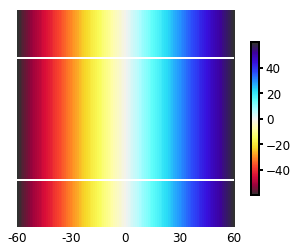

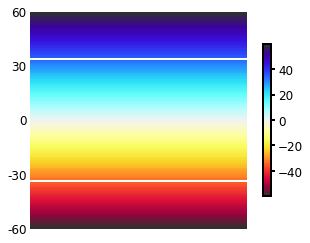

In [76]:

#### Some aggregate plotting stuff
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params(lw_axes=2)

screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=True, 
                                                   return_cmap=True)

#### Set output dirs
aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)

##### Metadata
#sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)
#retinodata = sdata[sdata['experiment']=='retino'].copy()
#retinodata.groupby(['visual_area']).count()

# Get retino runs
fovnum = int(fov.split('_')[0][3:])
datakey='%s_%s_fov%i' % (session, animalid, fovnum)


found_retinoruns = [os.path.split(d)[-1] for d in 
                    glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))]
print("Found %i runs" % len(found_retinoruns))
retinorun = found_retinoruns[0] if retinorun is None else retinorun

# Set current animal's retino output dir
run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
curr_dst_dir = os.path.join(run_dir, 'retino_analysis', 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
    print("Saving output to:\n %s" % curr_dst_dir)

# Params for processing/smoothing
processedparams_fpath = os.path.join(curr_dst_dir, 'processing_params.json')

In [77]:
# #### Processing maps
# az_fill, el_fill, pparams = seg.smooth_processed_maps(animalid, session, fov, retinorun=retinorun, 
#                                             target_sigma_um=target_sigma_um, 
#                                             start_with_transformed=start_with_transformed,
#                                             smooth_spline=smooth_spline, 
#                                             use_phase_smooth=use_phase_smooth, 
#                                             reprocess=True)
# with open(processedparams_fpath, 'w') as f:
#     json.dump(pparams, f, indent=4)

In [78]:
from pipeline.python.retinotopy import segment_retinotopy as seg

# seg.smooth_processed_maps()

#### Get processed maps

Current run: retino_run1
FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC076_20190423_FOV1_zoom2p0x_retino_run1_analysis001
Trials by cond:
{u'top': [15, 1, 2, 7], u'right': [11, 12, 14, 4], u'bottom': [10, 16, 6, 9], u'left': [13, 3, 5, 8]}
Original dims: [512, 512]
Data were downsampled by 2.
('got phase:', 1.696213901247745e-05, 6.283090174910583)
('got absolute:', -3.0700418371537355, 3.0900194634187006)
('Delay:', 0.05227506392457526, 6.230682834931168)


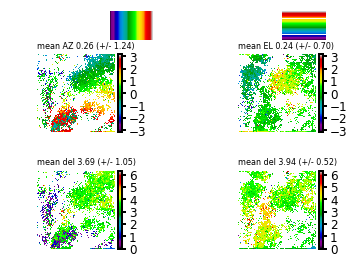

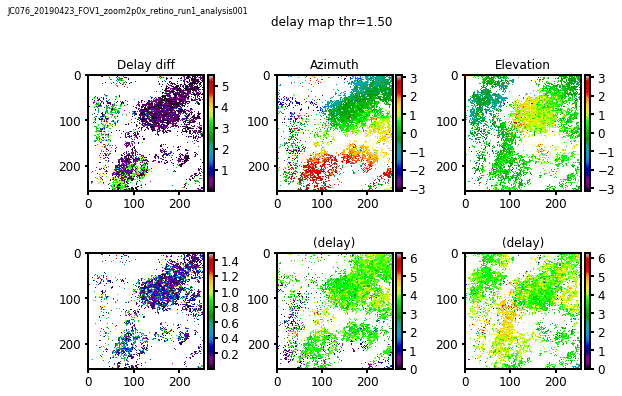

In [112]:
pix_mag_thr=0.002
delay_map_thr=1.5
# ---------------
smooth_spline=1
target_sigma_um=25 # 
start_with_transformed=True
use_phase_smooth=False
# -------------------------

pmaps, pparams = seg.get_processed_maps(animalid, session, fov, retinorun=retinorun,
                                    pix_mag_thr=pix_mag_thr, delay_map_thr=delay_map_thr,
                                    create_new=True, rootdir=rootdir)
curr_dst_dir = os.path.join(rootdir, animalid, session, fov, retinorun, 
                            'retino_analysis', 'segmentation')
data_id = '%s_%s_fov%i' % (session, animalid, int(fov.split('_')[0][3:]))

filt_az = pmaps['filtered_az']
filt_el = pmaps['filtered_el']
filt_azim_r = pmaps['filtered_az_scaled']
filt_elev_r = pmaps['filtered_el_scaled']
ds_factor = pparams['ds_factor']
delay_map_thr = pparams['delay_map_thr']
pix_mag_thr = pparams['pixel_mag_thr']
smooth_type = 'phasenan'if use_phase_smooth else 'gaussian'

#### Filter where delay map is not uniform (Az v El)

In [113]:
# delay_map_thr=1

# fig, filt_az, filt_el = ret_utils.filter_by_delay_map(absolute_az, absolute_el, delay_az, delay_el, 
#                                                         delay_map_thr=delay_map_thr, plot=True)

# filt_azim_r = coreg.transform_2p_fov(filt_az, pixel_size_ds, normalize=False)
# filt_elev_r = coreg.transform_2p_fov(filt_el, pixel_size_ds, normalize=False)

# putils.label_figure(fig, data_id)

# pl.savefig(os.path.join(curr_dst_dir, 'delay_map_filters.png'))

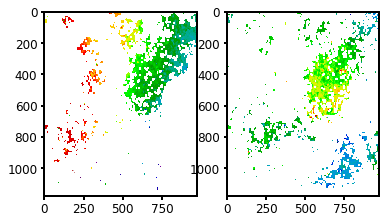

In [114]:
# Transform FOV to match widefield
f, axn = pl.subplots(1,2)
axn[0].imshow(filt_azim_r, cmap='nipy_spectral')
axn[1].imshow(filt_elev_r, cmap='nipy_spectral')



#### Smooth

In [117]:
smooth_type = 'phasenan'if use_phase_smooth else 'gaussian'
smooth_spline=2

# #### Smooth
start_az = filt_azim_r.copy() if start_with_transformed else filt_az.copy()
start_el = filt_elev_r.copy() if start_with_transformed else filt_el.copy()

# Get smooth sparams
pixel_size = putils.get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
um_per_pix = np.mean(pixel_size) if start_with_transformed else np.mean(pixel_size_ds)
smooth_fwhm = int(round(target_sigma_um/um_per_pix))  # int(25*pix_per_deg) #11

sm_azim, sm_elev = seg.smooth_maps(start_az, start_el, smooth_fwhm=smooth_fwhm, 
                                smooth_spline=smooth_spline,
                                start_with_transformed=start_with_transformed, 
                                use_phase_smooth=use_phase_smooth, ds_factor=ds_factor)

az_fill = sm_azim['final']
el_fill = sm_elev['final']

Target: 25 (fwhm=12)


('/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'pixelmaps_smooth-12_magthr-0.002_delaymapthr-1.50')


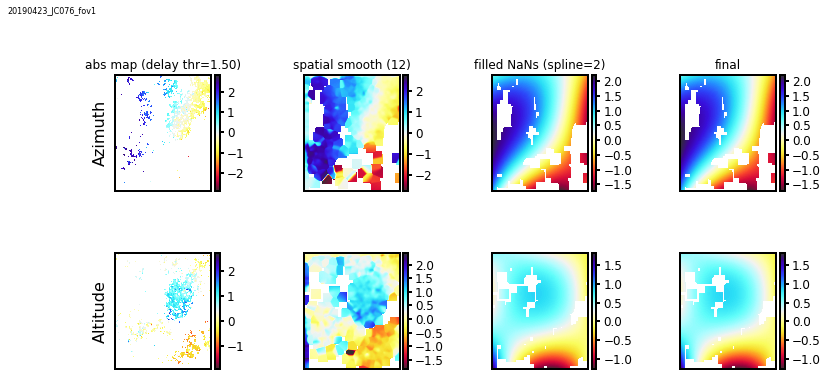

In [118]:
vmin, vmax = (-np.pi, np.pi)
fig = grd.plot_retinomap_processing_pixels(
                            start_az, sm_azim['smoothed'], sm_azim['nan_filled'], sm_azim['final'], 
                            start_el, sm_elev['smoothed'], sm_elev['nan_filled'], sm_elev['final'],
                                           cmap_phase=cmap_phase, vmin=vmin, vmax=vmax, \
                                           smooth_fwhm=smooth_fwhm, 
                                           smooth_spline=smooth_spline,
                                           delay_map_thr=delay_map_thr, 
                                           full_cmap_range=False, show_cbar=True)
putils.label_figure(fig, data_id)        
figname = 'pixelmaps_smooth-%i_magthr-%.3f_delaymapthr-%.2f' % (smooth_fwhm, pix_mag_thr, delay_map_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)


# Save 
smoothedmaps_fpath = os.path.join(curr_dst_dir, 'smoothed_maps.npz')
np.savez(smoothedmaps_fpath,
         start_az=start_az, start_el=start_el,
         azimuth=sm_azim['final'], elevation=sm_elev['final'])
smoothparams = {'smooth_fwhm': smooth_fwhm, 
                'smooth_spline': smooth_spline,
                'target_sigma_um': target_sigma_um, 
                'start_with_transformed': start_with_transformed,
                'use_phase_smooth': use_phase_smooth,
                'smooth_type': smooth_type}
pparams.update(smoothparams)

# Save
results_dir = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun, 'retino_analysis',
                        'segmentation'))
processingparams_fpath = os.path.join(results_dir[0], 'processing_params.json')
with open(processedparams_fpath, 'w') as f:
    json.dump(pparams, f, indent=4)


#### Smooth

In [119]:
# # Spatial smooth neuropil dilated masks 
# smooth_spline=1 # Make larger if >1 area, use fill_and_smooth_nans_missing()
# target_sigma_um=25 # # Marhsel et al 2014, make smaller if too much coverage? for some reson fill_and_smooth_nans_missing() fails if too covered

# start_with_transformed=True
# use_phase_smooth=False

# um_per_pix = np.mean(pixel_size) if start_with_transformed else np.mean(pixel_size_ds)
# smooth_fwhm = int(round(target_sigma_um/um_per_pix))  # int(25*pix_per_deg) #11
# sz=smooth_fwhm*2 #smooth_fwhm
# print("Target: %i (fwhm=%i)" % (target_sigma_um, smooth_fwhm)) #, sz)
# smooth_type = 'phasenan'if use_phase_smooth else 'gaussian'

# start_az = filt_azim_r.copy() if start_with_transformed else filt_az.copy()
# start_el = filt_elev_r.copy() if start_with_transformed else filt_el.copy()

# if use_phase_smooth:
#     azim_smoothed = ret_utils.smooth_phase_nans(start_az, smooth_fwhm, sz)
#     elev_smoothed = ret_utils.smooth_phase_nans(start_el, smooth_fwhm, sz)
# else:
#     azim_smoothed = ret_utils.smooth_neuropil(start_az, smooth_fwhm=smooth_fwhm)
#     elev_smoothed = ret_utils.smooth_neuropil(start_el, smooth_fwhm=smooth_fwhm)

# #azim_fillnan = grd.fill_and_smooth_nans(azim_smoothed, kx=smooth_spline, ky=smooth_spline)
# #elev_fillnan = grd.fill_and_smooth_nans(elev_smoothed, kx=smooth_spline, ky=smooth_spline)
# if len(np.where(np.isnan(azim_smoothed))[0])>0:
#     azim_fillnan = grd.fill_and_smooth_nans_missing(azim_smoothed, kx=smooth_spline, ky=smooth_spline)
# else:
#     #azim_fillnan = azim_smoothed.copy()
#     azim_fillnan = grd.fill_and_smooth_nans(azim_smoothed, kx=smooth_spline, ky=smooth_spline)
# if len(np.where(np.isnan(elev_smoothed))[0])>2500:
#     elev_fillnan = grd.fill_and_smooth_nans_missing(elev_smoothed, kx=smooth_spline, ky=smooth_spline)
# else:
#     #elev_fillnan = elev_smoothed.copy()
#     elev_fillnan = grd.fill_and_smooth_nans(elev_smoothed, kx=smooth_spline, ky=smooth_spline)
# # Transform FOV to match widefield
# az_fill = coreg.transform_2p_fov(azim_fillnan, pixel_size, normalize=False) if not start_with_transformed else azim_fillnan
# el_fill = coreg.transform_2p_fov(elev_fillnan, pixel_size, normalize=False) if not start_with_transformed else elev_fillnan

# #az_fill = azim_r.copy()
# #el_fill = elev_r.copy()
# vmin, vmax = (-np.pi, np.pi)

# fig = grd.plot_retinomap_processing_pixels(start_az, azim_smoothed, azim_fillnan, az_fill,
#                                            start_el, elev_smoothed, elev_fillnan, el_fill,
#                                          cmap_phase=cmap_phase, vmin=vmin, vmax=vmax, \
#                                            smooth_fwhm=smooth_fwhm, smooth_spline=smooth_spline,
#                                          delay_map_thr=delay_map_thr, full_cmap_range=False, show_cbar=True)

# putils.label_figure(fig, data_id)
# figname = 'pixelmaps_smooth-%i_magthr-%.3f_delaymapthr-%.2f' % (smooth_fwhm, pix_mag_thr, delay_map_thr)
# pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
# print(curr_dst_dir, figname)



# ----------------------------------
# MANUAL
# ----------------------------------

In [120]:
# curr_visual_area='Li'
# retinodata[retinodata['visual_area']==curr_visual_area].sort_values(by='animalid')

# Do it all in one go

In [121]:
# datakey = '20190605_JC090_fov1'
# session, animalid, fovn = datakey.split('_')
# fovnum = int(fovn[3:])


# fov = 'FOV%i_zoom2p0x' % fovnum
# traceid = 'traces001'

# datakey='%s_%s_fov%i' % (session, animalid, fovnum)

# # Get retino runs
# found_retinodirs = glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))
# found_retinoruns = [os.path.split(d)[-1] for d in found_retinodirs]
# print("Found %i runs" % len(found_retinoruns))

# # Set current animal's retino output dir
# run_ix = 0
# retinorun = found_retinoruns[run_ix]
# curr_dst_dir = os.path.join(found_retinodirs[run_ix], 'retino_analysis', 'segmentation')
# print(curr_dst_dir)

# data_id = '_'.join([animalid, session, fov, retinorun, traceid])


In [122]:
# delay_map_thr = 0.5
# pix_mag_thr = 0.002
# smooth_fwhm = 5
# smooth_spline=2
# cmap_name = 'nic_Edge'
# # ----------------------------------------------------------

# az_fill, el_fill, params, RETID = grd.pixel_gradients(animalid, session, fov, traceid=traceid, retinorun=retinorun, 
#                                                       mag_thr=pix_mag_thr, delay_map_thr=delay_map_thr, 
#                                                       dst_dir=curr_dst_dir, cmap=cmap_name, 
#                                                       smooth_fwhm=smooth_fwhm, smooth_spline=smooth_spline,
#                                                       full_cmap_range=False) 


## Get surface img

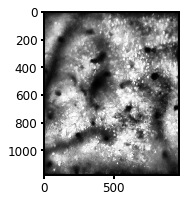

In [123]:
# screen info
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

#### Convert to screen units
vmin, vmax = (-np.pi, np.pi)
img_az = putils.convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = putils.convert_range(el_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)   

#### Get surface img
surface_img = ret_utils.load_2p_surface(animalid, session, fov, ch_num=1, retinorun=retinorun)
pixel_size = putils.get_pixel_size()
surface_2p = coreg.transform_2p_fov(surface_img, pixel_size, normalize=False)
surface_2p = putils.adjust_image_contrast(surface_2p, clip_limit=10.0, tile_size=5)
fig, ax = pl.subplots(figsize=(4,3))
ax.imshow(surface_2p, cmap='gray')

In [124]:
# if surface_img.shape[0] != absolute_az.shape[0]:
#     reduce_factor = surface_img.shape[0] / absolute_az.shape[0]
#     surface_img = block_reduce(surface_img, (2,2), func=np.mean)

# # transform to physical view
# surface_transf = coreg.orient_2p_to_macro(surface_img, zoom_factor=1., save=False, normalize=True)
# surface_r = coreg.scale_2p_fov(surface_transf, pixel_size=pixel_size)

# surface = putils.adjust_image_contrast(surface_r, clip_limit=2.0, tile_size=5)

# #print(surface_r.shape)
# f, ax = pl.subplots(figsize=(4,4))
# ax.imshow(surface)


# Identify borders using the gradients


# Segement areas

In [148]:
# Segmenting params
sign_map_thr = 0.1
min_region_area = 2000
# -------------------------------------------------------------------

# Create sign map 
O, S_thr = seg.segment_areas(img_az, img_el, sign_map_thr=sign_map_thr)

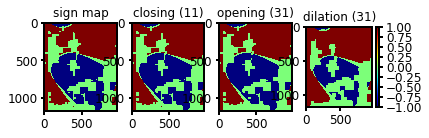

In [149]:
absolute_S_thr=False
close_k =11
open_k = 31
dilate_k = 31

#S=S_thr.copy() #np.sign(O) # Discretize into patches
S = abs(S_thr) if absolute_S_thr else S_thr.copy()
S[np.isnan(O)]=0



# Morphological steps
S, closing_s1, opening_s1, dilation = seg.do_morphological_steps(S,
                                            close_k=close_k, open_k=open_k, dilate_k=dilate_k)
sfig = seg.plot_morphological_steps(S, closing_s1, opening_s1, dilation, 
                                            close_k=close_k, open_k=open_k, dilate_k=dilate_k) 



# close_k = 1
# niter = 1
# kernel =  np.ones((close_k, close_k))
# closing_s1 = cv2.morphologyEx(S, cv2.MORPH_CLOSE, kernel, iterations=niter)

# dilate_k = 151
# niter=1
# kernel = np.ones((dilate_k, dilate_k))
# opening_s1 = cv2.morphologyEx(closing_s1, cv2.MORPH_OPEN, kernel, iterations=niter)

# k3 = 91 #close_k
# niter = 1
# kernel = np.ones((k3, k3))
# dilation = cv2.dilate(opening_s1, kernel, iterations=niter)
# # dilation = cv2.morphologyEx(opening_1, cv2.MORPH_CLOSE, kernel, iterations=niter)

# #nozeros[S==0] = np.nan
# #test_sm = grd.fill_nans(dilation)
# f, axf = pl.subplots(1,4) #pl.figure()
# axn = axf.flat
# ax=axn[0]
# ax.set_title("sign map")
# ax.imshow(S,cmap='jet')

# ax=axn[1]
# im=ax.imshow(closing_s1, cmap='jet')
# ax.set_title('closing  -ignore')

# ax=axn[2]
# im=ax.imshow(opening_s1, cmap='jet')
# ax.set_title('opening')


# ax=axn[3]
# im=ax.imshow(dilation, cmap='jet')
# putils.colorbar(im)
# ax.set_title('dilation')

#### Test w/ morphological steps


#### Update segmentation params

In [150]:
# seg_params = {'pixel_mag_thr': pix_mag_thr,
#               'downsample_factor': ds_factor,
#               'delay_map_thr': delay_map_thr,
#               'smooth_fwhm': smooth_fwhm,
#               'smooth_spline': smooth_spline,
#               'smooth_type': smooth_type,
#               'start_with_transformed': start_with_transformed,
#               'dilate_k': dilate_k,
#               'close_k': close_k,
#               'absolute_S_thr': absolute_S_thr,
#               'sign_map_thr': sign_map_thr,
#               'min_region_area': min_region_area,
#               'retino_id': retinoid, 
#               'retino_run': retinorun}


# #### Update segmentation params
seg_params = pparams.copy()
seg_params.update({'morphological_kernels': (close_k, open_k, dilate_k),
                   'absolute_S_thr': absolute_S_thr,
                   'sign_map_thr': sign_map_thr,
                   'min_region_area': min_region_area})



((1177, 972), (1177, 972, 3))
Found 7 regions: [1, 2, 3, 4, 5, 6, 7]


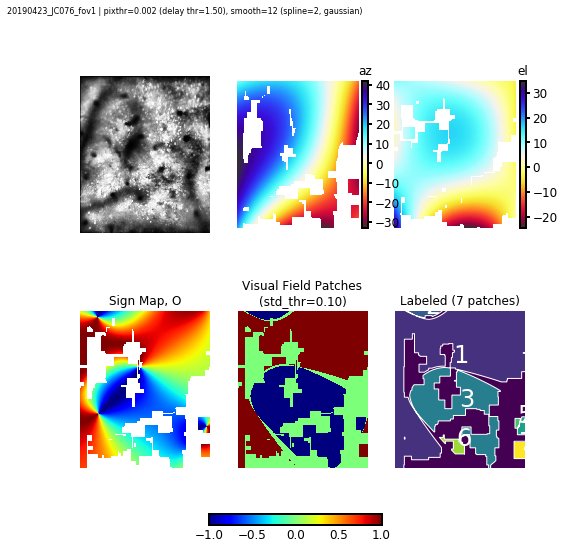

In [151]:
# # Label image
# region_props, labeled_image  = seg.segment_and_label(dilation)
# region_labels = [region.label for region in region_props]
# print('Found %i regions: %s' % (len(region_labels), str(region_labels)))

# # Save
# orig_d1, orig_d2 = surface_2p.shape
# labeled_image_2p = cv2.resize(labeled_image.astype(np.uint8), (orig_d2, orig_d1)) #surface_2p.shape)
# results = {'labeled_image_ds': labeled_image, 
#            'labeled_image': labeled_image_2p,
#            'region_props': region_props}


#### Label image
region_props, labeled_image  = seg.segment_and_label(dilation, min_region_area=min_region_area)
region_labels = [region.label for region in region_props]
print('Found %i regions: %s' % (len(region_labels), str(region_labels)))

##### Save
orig_d1, orig_d2 = surface_2p.shape
labeled_image_2p = cv2.resize(labeled_image.astype(np.uint8), (orig_d2, orig_d1))
results = {'labeled_image_ds': labeled_image, 
           'labeled_image': labeled_image_2p,
           'region_props': region_props}


##### Plot segmentation results
proc_info_str = 'pixthr=%.3f (delay thr=%.2f), smooth=%i (spline=%i, %s)' % (pix_mag_thr, delay_map_thr, smooth_fwhm, smooth_spline, smooth_type)
fig = seg.plot_segmentation_steps(img_az, img_el, surface=surface_2p, O=O, S_thr=S_thr, 
                                params=seg_params, cmap=cmap_phase, 
                                labeled_image=labeled_image, region_props=region_props, 
                                label_color='w')
putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.subplots_adjust(hspace=0.5, bottom=0.2) 
pl.savefig(os.path.join(curr_dst_dir, 'segemented_areas.png'))
pl.show()

In [152]:
# # Plot segmentation results
# proc_info_str = 'pixthr=%.3f (delay thr=%.2f), smooth=%i (spline=%i, %s)' % (pix_mag_thr, delay_map_thr, smooth_fwhm, smooth_spline, smooth_type)
# fig = seg.plot_segmentation_steps(img_az, img_el, surface=surface_2p, O=O, S_thr=S_thr, params=seg_params, 
#                                cmap=cmap_phase, labeled_image=labeled_image, region_props=region_props, label_color='w')

# putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
# pl.subplots_adjust(hspace=0.5, bottom=0.2)
    
# pl.savefig(os.path.join(curr_dst_dir, 'segemented_areas.png'))

# Select areas and label

In [64]:
reload(seg)

<module 'pipeline.python.retinotopy.segment_retinotopy' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/segment_retinotopy.pyc'>

('Lm', 525777)
('PL', 206337)


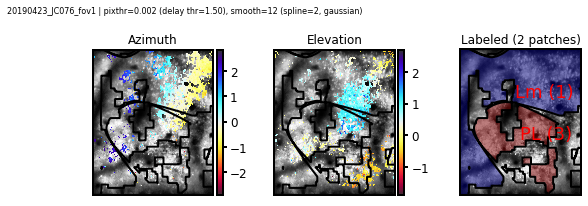

In [155]:
region_dict={1: 'Lm', 3:'PL'} #,5:'Lm'} #, 2: 'AL', 4: 'Li'} #V1'}


#region_dict={1: 'Lm'} #,5:'Lm'} #, 2: 'AL', 4: 'Li'} #V1'}
seg_areas = {}
for ri, region in enumerate(region_props):
    region_id = region.label
    if region.label in region_dict.keys():
        region_name = region_dict[region.label]
    else:
        region_name = region.label
    # save mask
    region_mask = np.copy(labeled_image.astype('float'))
    region_mask[labeled_image != region_id] = 0
    region_mask[labeled_image == region_id] = 1
    if region_name in seg_areas.keys():
        region_mask = seg_areas[region_name]['mask'] + region_mask # Update region mask
        region_id = seg_areas[region_name]['id']
        labeled_image[region_mask==1] = seg_areas[region_name]['id'] # Update labeled image
    seg_areas[region_name] = {'id': region_id, 'mask': region_mask}


# double check labeling/naming of segmented areas
label_keys = [(k, v['id']) for k, v in seg_areas.items() if not(putils.isnumber(k))]
results.update({'areas': seg_areas})
results.update({'label_keys': label_keys})

# Plot results with segmented areas
pos_multiplier = (1,1) if start_with_transformed else (pixel_size[0], pixel_size[1]) 
area_ids = [k[1] for k in label_keys]
labeled_image_incl = np.ones(labeled_image.shape)*np.nan #labeled_image.copy()
for idx in area_ids:
    labeled_image_incl[labeled_image==idx] = idx

fig = seg.plot_labeled_areas(filt_azim_r, filt_elev_r, surface_2p, label_keys,
                        labeled_image_2p, labeled_image_incl,
                        region_props, cmap_phase=cmap_phase, pos_multiplier=pos_multiplier)
pl.subplots_adjust(wspace=0.3, top=0.8)
putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.savefig(os.path.join(curr_dst_dir, 'labeled_areas.png'))


    
# seg_areas = {}
# for ri, region in enumerate(region_props):
#     region_id = region.label
#     if region.label in region_dict.keys():
#         region_name = region_dict[region.label]
#         #label_keys.append((region_name, region_id))
#     else:
#         region_name = region.label

#     # save mask
#     region_mask = np.copy(labeled_image.astype('float'))
#     region_mask[labeled_image != region_id] = 0
#     region_mask[labeled_image == region_id] = 1
#     if region_name in seg_areas.keys():
#         region_mask = seg_areas[region_name]['mask'] + region_mask # Update region mask
#         region_id = seg_areas[region_name]['id']
#         labeled_image[region_mask==1] = seg_areas[region_name]['id'] # Update labeled image
#     seg_areas[region_name] = {'id': region_id, 'mask': region_mask}

# label_keys = [(k, v['id']) for k, v in seg_areas.items() if not(putils.isnumber(k))]

# # double check labeling/naming of segmented areas
# pos_multiplier = (1,1) if start_with_transformed else (pixel_size[0], pixel_size[1]) 
# area_ids = [k[1] for k in label_keys]
# labeled_image_incl = np.ones(labeled_image.shape)*np.nan #labeled_image.copy()
# for idx in area_ids:
#     labeled_image_incl[labeled_image==idx] = idx

# # Transform FOV to match widefield
# fig, axn = pl.subplots(1,3, figsize=(9,3))
# ax=axn[0]
# ax.imshow(surface_2p, cmap='gray')
# ax.set_title('Azimuth')
# im0 = ax.imshow(filt_azim_r, cmap=cmap_phase)
# putils.colorbar(im0)
# ax = seg.overlay_all_contours(labeled_image_2p, ax=ax, lw=2, lc='k')
# putils.turn_off_axis_ticks(ax, despine=False)

# ax=axn[1]
# ax.imshow(surface_2p, cmap='gray')
# im1=ax.imshow(filt_elev_r, cmap=cmap_phase)
# putils.colorbar(im1)
# ax.set_title('Elevation')
# ax = seg.overlay_all_contours(labeled_image_2p, ax=ax, lw=2, lc='k')
# putils.turn_off_axis_ticks(ax, despine=False)

# ax=axn[2]
# ax.imshow(surface_2p, cmap='gray')
# labeled_image_incl_2p = cv2.resize(labeled_image_incl, (surface_2p.shape[1], surface_2p.shape[0]))
# ax.imshow(labeled_image_incl_2p, cmap='jet', alpha=0.5)
# ax = seg.overlay_all_contours(labeled_image_2p, ax=ax, lw=2, lc='k')

# for region in region_props:
#     if region.label in area_ids:
#         region_name = str([k[0] for k in label_keys if k[1]==region.label][0])
#         ax.text(region.centroid[1]*pos_multiplier[0], region.centroid[0]*pos_multiplier[1], 
#                         '%s (%i)' % (region_name, region.label), fontsize=18, color='r')
#         print(region_name, region.area)
# ax.set_title('Labeled (%i patches)' % len(area_ids))
# putils.turn_off_axis_ticks(ax, despine=False)

# putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
# pl.savefig(os.path.join(curr_dst_dir, 'labeled_areas.png'))

# pl.subplots_adjust(wspace=0.3, top=0.8)

In [156]:
results.keys()

['labeled_image', 'region_props', 'labeled_image_ds', 'label_keys', 'areas']

## Save results

In [157]:
# # Load data metainfo
# print("Current run: %s" % retinorun)
# retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
# data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
# print("DATA ID: %s" % data_id)

# # Get ROIID and projection image
# ds_factor = int(RETID['PARAMS']['downsample_factor'])
# print('Data were downsampled by %i.' % ds_factor)

# segparams_fpath = os.path.join(curr_dst_dir, 'params.json')
# segresults_fpath = os.path.join(curr_dst_dir, 'results.pkl')

# results.update({'areas': seg_areas})
# results.update({'label_keys': label_keys})

# with open(segparams_fpath, 'w') as f:
#     json.dump(seg_params, f, indent=4, sort_keys=True)
    
# with open(segresults_fpath, 'wb') as f:
#     pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)



# ## Save results
segparams_fpath = os.path.join(curr_dst_dir, 'params.json')
with open(segparams_fpath, 'w') as f:
    json.dump(seg_params, f, indent=4, sort_keys=True) 
    
segresults_fpath = os.path.join(curr_dst_dir, 'results.pkl')
with open(segresults_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

print("Completed segmentation!")
print(curr_dst_dir)

Completed segmentation!
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation


# Do stuff with segementations

## Calculate gradient for segmented areas

In [158]:
seg_results, seg_params = seg.load_segmentation_results(animalid, session, fov, retinorun=retinorun)
segmented_areas = seg_results['areas']
region_props = seg_results['region_props']

(0, 2)
(1, 4)
(2, 5)
(3, 6)
(4, 7)
(5, 'Lm')
('/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'gradients_Lm')
(6, 'PL')
('/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'gradients_PL')


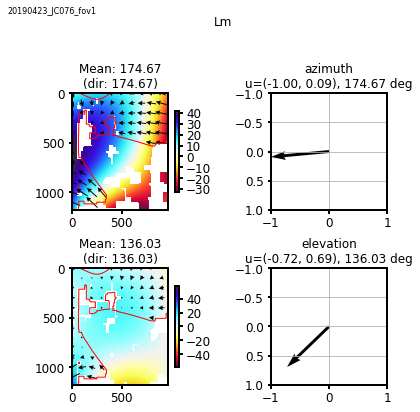

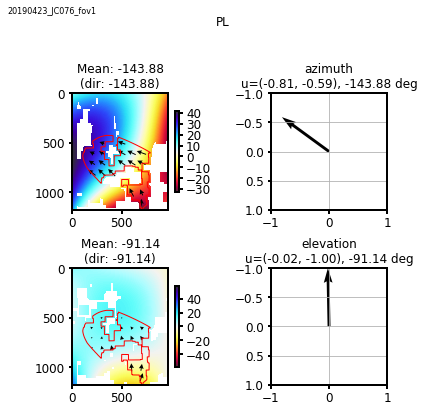

In [159]:
contour_lc='r'
contour_lw=1
spacing =100
scale = 0.001 #0.0001
width = 0.01 #1 #0.01
headwidth=5

for vi, (curr_visual_area, area_results) in enumerate(segmented_areas.items()):
    print(vi, curr_visual_area)
    if putils.isnumber(curr_visual_area):
        continue
    curr_segmented_mask = area_results['mask']
    grad_az, grad_el = seg.calculate_gradients(curr_segmented_mask, img_az, img_el)
    
    # Plot results ------------
    curr_labeled_image = np.zeros(labeled_image.shape)
    curr_labeled_image[labeled_image==area_results['id']] = 1
    fig = seg.plot_gradients_in_area(curr_labeled_image, img_az, img_el, grad_az, grad_el, cmap_phase=cmap_phase,
                                 contour_lc=contour_lc, contour_lw=contour_lw, spacing=spacing, 
                                 scale=scale, width=width, headwidth=headwidth)
    pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8)
    putils.label_figure(fig, data_id)
    fig.suptitle(curr_visual_area)

    figname = 'gradients_%s' % curr_visual_area
    pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
    print(curr_dst_dir, figname)


## Assign cells to visual area(s)

# Load data

In [160]:
#### Get roi masks 
traceid= 'traces001'
roi_id = None
if roi_id is None:
    roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
r_masks, zprog_img = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
print("Loaded rois: %s" % roi_id)
d1, d2, nrois = r_masks.shape

##### Reshape and transform to match 'natural view'
pixel_size = putils.get_pixel_size() #* ds_factor
roi_masks_tr = np.dstack([coreg.transform_2p_fov(r_masks[:, :, i].astype(float), pixel_size) \
               for i in np.arange(0, nrois)]) # transform/orient
roi_masks = roi_masks_tr.astype(bool).astype(int)
print(roi_masks.shape)

Loaded rois: rois001
(1177, 972, 323)


## Load segmentation results

In [161]:
seg_results, seg_params = seg.load_segmentation_results(animalid, session, fov, retinorun=retinorun)
seg_areas = seg_results['areas']

## Assign roi IDs to visual area

Assigning rois to visual areas...
('Roi masks:', 1177, 972, 323)
(2, 0)
(4, 2)
(5, 4)
(6, 13)
(7, 2)
('Lm', 165)
('PL', 100)
plotting assigned rois


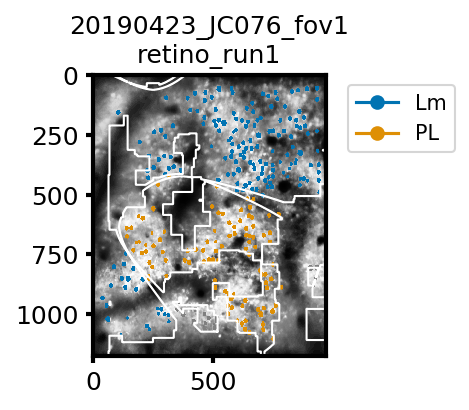

In [162]:
id_cmap='colorblind'
contour_lw=1
contour_lc='w'

#return_labeled_masks=False
verbose=False
create_new = True


if not create_new:
    try:
        print("Loading roi assignments")
        roi_assignments = seg.load_roi_assignments(animalid, session, fov, retinorun=retinorun)
    except AssertionError:
        create_new=True

plot_rois = True

if create_new:
    print("Assigning rois to visual areas...")
    # Assign each ROI to visual areas
    roi_assignments = seg.label_roi_masks(seg_results, roi_masks)

    # Save assignments
    assignments_fpath = os.path.join(curr_dst_dir, 'roi_assignments.json')
    with open(assignments_fpath, 'w') as f:
        json.dump(roi_assignments, f, indent=4)
    create_new=False

if plot_rois:
    print("plotting assigned rois")
    labeled_image = seg_results['labeled_image']
    f, ax = pl.subplots(figsize=(2,3), dpi=dpi)
    seg.plot_labeled_rois(labeled_image, roi_assignments, roi_masks, cmap=id_cmap, surface=surface_2p, ax=ax,
                     contour_lw=contour_lw, contour_lc=contour_lc)
    
    putils.label_figure(fig, data_id)
    ax.set_title('%s\n%s' % (datakey, retinorun))
    pl.savefig(os.path.join(curr_dst_dir, 'assigned_rois.svg'))


In [41]:
seg_params

{u'absolute_S_thr': False,
 u'delay_map_thr': 0.8,
 u'dims': [512, 512],
 u'ds_factor': 2,
 u'min_region_area': 2000,
 u'morphological_kernels': [31, 31, 1],
 u'pixel_mag_thr': 0.002,
 u'pixel_size': [2.3, 1.9],
 u'retino_id': u'analysis001',
 u'retino_run': u'retino_run2',
 u'sign_map_thr': 0.1,
 u'smooth_fwhm': 12,
 u'smooth_spline': 1,
 u'smooth_type': u'gaussian',
 u'start_with_transformed': True,
 u'target_sigma_um': 25,
 u'use_phase_smooth': False}

In [205]:
u'use_phase_smooth

'gaussian'